# Annotating regions of interest with `napari`

We will show:
1. how to use `napari` for drawing regions of interesets and how to access these annotations via code.
2. assuming these saved regions are anatomical regions of interterest, how to extract the Visium spots/cells under these regions.

For the sake of generality, instead of annotating the untransformed data, we will assign an affine transformation to the data and show that annotations and query APIs work in any coordinate system.

In [1]:
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
import spatialdata as sd
from geopandas import GeoDataFrame
from shapely import Polygon
from spatialdata.models import ShapesModel
from spatialdata.transformations import Identity

import spatialdata_plot  # noqa: F401

# from napari_spatialdata import Interactive

/opt/miniconda3/envs/ome/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/ome/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Please download the Visium data from here: [Visium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_associated_xenium_io.zip). We will align the file, as shown in [this analysis notebook](https://github.com/scverse/spatialdata-notebooks/blob/main/notebooks/examples/alignment_using_landmarks.ipynb).

Please rename the file to `visium.zarr` and place it in the same folder as this notebook (or use symlinks to make the data accessible).

In [3]:
visium_sdata = sd.read_zarr("visium.zarr")

/opt/miniconda3/envs/ome/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/opt/miniconda3/envs/ome/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/opt/miniconda3/envs/ome/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/opt/miniconda3/envs/ome/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/opt/miniconda3/envs/ome/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwa

In [4]:
visium_sdata

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-data-converter/dependencies/spatialdata-sandbox/visium_associated_xenium_io/data.zarr
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': DataTree[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': DataArray[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': DataArray[cyx] (3, 600, 543)
├── Shapes
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
│     └── 'visium_landmarks': GeoDataFrame shape: (3, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (4992, 18085)
with coordinate systems:
    ▸ 'CytAssist_FFPE_Human_Breast_Cancer', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), CytAssist_FFPE_Human_Breast_Cancer_hires_image (Images), CytAssist_FFPE_Human_Breast_Cancer_lowre

In [5]:
visium_sdata["table"].var

,gene_ids,feature_types,genome
SAMD11,ENSG00000187634,Gene Expression,GRCh38
NOC2L,ENSG00000188976,Gene Expression,GRCh38
KLHL17,ENSG00000187961,Gene Expression,GRCh38
PLEKHN1,ENSG00000187583,Gene Expression,GRCh38
PERM1,ENSG00000187642,Gene Expression,GRCh38
...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,GRCh38
MT-ND4,ENSG00000198886,Gene Expression,GRCh38
MT-ND5,ENSG00000198786,Gene Expression,GRCh38
MT-ND6,ENSG00000198695,Gene Expression,GRCh38


Let's plot the data before adding an affine transformation to it.  

/opt/miniconda3/envs/ome/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Human_Breast_Cancer` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/opt/miniconda3/envs/ome/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


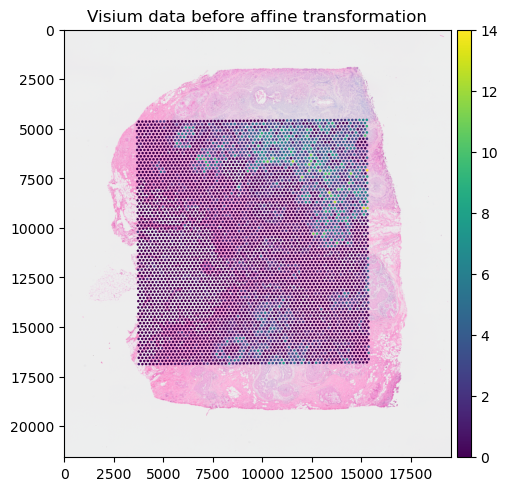

In [6]:
(
    visium_sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image")
    .pl.render_shapes("CytAssist_FFPE_Human_Breast_Cancer", color="SAMD11")
    .pl.show(
        coordinate_systems="CytAssist_FFPE_Human_Breast_Cancer",
        title="Visium data before affine transformation",
    )
)

We use the same affine transformation derived in the ["Alignemnt using landmarks" tutorial](alignment_using_landmarks.ipynb). For convenience, we will import the affine transformation and the `postpone_transformation()` function from a utils file.

In [29]:
from alignment_utils import AFFINE_VISIUM_XENIUM, postpone_transformation

print(AFFINE_VISIUM_XENIUM)

postpone_transformation(
    sdata=visium_sdata,
    transformation=AFFINE_VISIUM_XENIUM,
    source_coordinate_system="CytAssist_FFPE_Human_Breast_Cancer",
    target_coordinate_system="aligned",
)

Affine (x, y -> x, y)
    [ 1.61711846e-01  2.58258090e+00 -1.24575040e+04]
    [-2.58258090e+00  1.61711846e-01  3.98647301e+04]
    [0. 0. 1.]


/opt/miniconda3/envs/ome/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Human_Breast_Cancer` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/opt/miniconda3/envs/ome/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


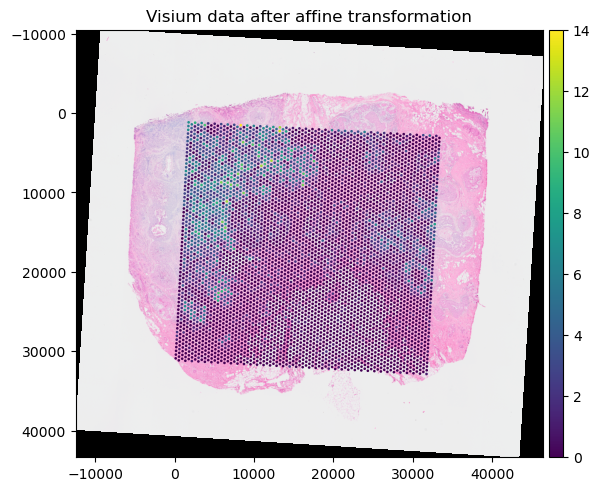

In [28]:
(
    visium_sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image")
    .pl.render_shapes("CytAssist_FFPE_Human_Breast_Cancer", color="SAMD11")
    .pl.show(
        coordinate_systems="aligned",
        title="Visium data after affine transformation",
    )
)

## Adding shapes annotations

We can use `napari` to draw rectangles and generic polygons.

This is the procedure to annotate and save the shapes (shown in the GIF):
1. open `napari` with `Interactive()` from `napari_spatialdata`
2. create a new Shapes layer in napari
3. (optional) rename the layer
4. (optional) change the fill and border propoerties for easier visualization
5. select the "Rectangle tool" or the "Polygon tool"
6. (optional) use the `napari` functions to move/delete/modify the shapes (shown later)
7. save the annotation to the `SpatialData` object by pressing `Shift + E` (if you called `Interactive()` passing multiple `SpatialData` objects, the annotations will be saved to one of them).


![](attachments/rois0.gif)

When pressing `Shift + E`, the shapes are saved. Anyway, for making this notebook reproducible, let's manually hardcode the shapes that have been drawn in the GIF above. The code produces data that is equivalent to the one given by `napari`. Note that we could have also put the shapes in a new `SpatialData` objects, saved this to Zarr and loaded it here.

In [10]:
shape0 = np.array(
    [
        [7758.0, 11577.0, 11577.0, 7758.0, 7758.0],
        [10928.0, 10928.0, 17197.0, 17197.0, 10928.0],
    ]
)

shape1 = np.array(
    [
        [11721.0, 14712.0, 14712.0, 11721.0, 11721.0],
        [12117.0, 12117.0, 16801.0, 16801.0, 12117.0],
    ]
)
# fmt: off
shape2 = np.array(
    [
        [
            31320.0,28114.0,26745.0,26060.0,22998.0,23863.0,23899.0,29159.0,29195.0,32113.0,31789.0,33230.0,31320.0,
        ],
        [
            23286.0,20764.0,20836.0,19215.0,18170.0,15756.0,12081.0,12766.0,14567.0,17125.0,18530.0,20692.0,23286.0,
        ],
    ]
)
# fmt: on


def numpy_to_shapely(x: np.array) -> Polygon:
    return Polygon(list(map(tuple, x.T)))


gdf = GeoDataFrame(
    {
        "geometry": [
            numpy_to_shapely(shape0),
            numpy_to_shapely(shape1),
            numpy_to_shapely(shape2),
        ]
    }
)
gdf = ShapesModel.parse(gdf, transformations={"aligned": Identity()})
visium_sdata.shapes["my_shapes"] = gdf

Importantly, notice how the shapes `"my_shapes"`, now available in the `SpatialData` object, are aligned to the `"aligned"` coordinate system. This is because the shapes have been drawn when the coordinate system `"aligned"` was selected in `napari`.

In [11]:
visium_sdata

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-data-converter/dependencies/spatialdata-sandbox/visium_associated_xenium_io/data.zarr
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': DataTree[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': DataArray[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': DataArray[cyx] (3, 600, 543)
├── Shapes
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
│     ├── 'my_shapes': GeoDataFrame shape: (3, 1) (2D shapes)
│     └── 'visium_landmarks': GeoDataFrame shape: (3, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (4992, 18085)
with coordinate systems:
    ▸ 'CytAssist_FFPE_Human_Breast_Cancer', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), CytAssist_FFPE_Human_Breast_Cancer_

The shapes are stored in a `geopandas.GeoDataFrame` as `shapely.Polygon` objects. Hence we can use them in any `geopandas`/`shapely` workflow.

In [12]:
visium_sdata["my_shapes"]

,geometry
0,"POLYGON ((7758 10928, 11577 10928, 11577 17197..."
1,"POLYGON ((11721 12117, 14712 12117, 14712 1680..."
2,"POLYGON ((31320 23286, 28114 20764, 26745 2083..."


We can quickly see the shapes in the notebook (thanks to `shapely`). For more complex visualization involving different elements or different coordinate system we can rely on `spatialdata-plot`.

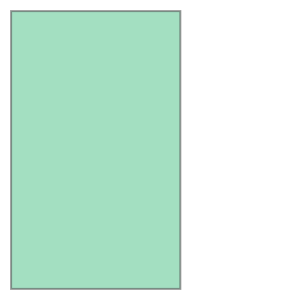

In [13]:
visium_sdata["my_shapes"].geometry.iloc[0]

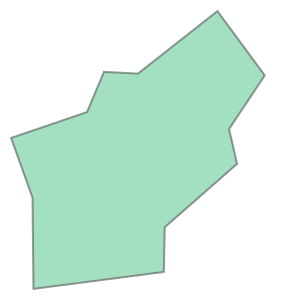

In [14]:
visium_sdata["my_shapes"].geometry.iloc[2]

## Manipulating the shapes in napari

Here is an example of how we can use napari to move/modify/delete some of the shapes, and save them to another layer (in-place overwrite is also supported).

Interactive(visium_sdata)

![](attachments/rois1.gif)

We saved the new layer as `my_shapes_2` inside the same `SpatialData` object (again using the `"aligned"` coordinate system).

As above, let's hardcode the shapes to make this notebook reproducible.

In [15]:
shape0 = np.array(
    [
        [3471.0, 7290.0, 7290.0, 3471.0, 3471.0],
        [5848.0, 5848.0, 12117.0, 12117.0, 5848.0],
    ]
)

shape1 = np.array(
    [
        [18278.0, 21269.0, 21269.0, 18278.0, 18278.0],
        [3435.0, 3435.0, 8118.0, 8118.0, 3435.0],
    ]
)

# fmt: off
shape2 = np.array(
    [
        [
            37049.0,28114.0,26745.0,26060.0,4696.0,23863.0,25160.0,29159.0,29195.0,32113.0,31789.0,33230.0,37049.0,
        ],
        [
            34274.0,20764.0,20836.0,19215.0,20116.0,15756.0,84.0,12766.0,14567.0,17125.0,18530.0,20692.0,34274.0,
        ],
    ]
)
# fmt: on

gdf = GeoDataFrame(
    {
        "geometry": [
            numpy_to_shapely(shape0),
            numpy_to_shapely(shape1),
            numpy_to_shapely(shape2),
        ]
    }
)
gdf = ShapesModel.parse(gdf, transformations={"aligned": Identity()})
visium_sdata.shapes["my_shapes_2"] = gdf

In [16]:
visium_sdata

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-data-converter/dependencies/spatialdata-sandbox/visium_associated_xenium_io/data.zarr
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': DataTree[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': DataArray[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': DataArray[cyx] (3, 600, 543)
├── Shapes
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
│     ├── 'my_shapes': GeoDataFrame shape: (3, 1) (2D shapes)
│     ├── 'my_shapes_2': GeoDataFrame shape: (3, 1) (2D shapes)
│     └── 'visium_landmarks': GeoDataFrame shape: (3, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (4992, 18085)
with coordinate systems:
    ▸ 'CytAssist_FFPE_Human_Breast_Cancer', with elements:
        CytAssist_FFPE_Human_Breast

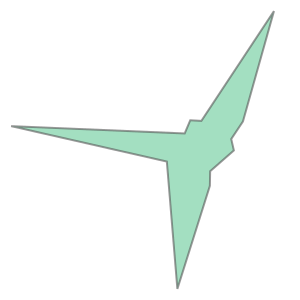

In [17]:
visium_sdata["my_shapes_2"].geometry.iloc[2]

## Lasso annotations
We are working with the `napari` developers for enabling a lasso tool for drawing anatomical annotations. This functionality will be part of `napari` as a new button in the user interface. With `SpatialData` it will be possible to save and represent the annotatoins in-memory, as shown above. The lasso tool will have support for both mouse/trackpad and graphic tables.

In the GIF you can see a preview, the experimental code is available at https://github.com/napari/napari/pull/5555.

![](attachments/rois2.gif)

In [18]:
# we rounded the coordinates to make it less verbose here in the notebook
# fmt: off
shape0 = (
    np.array(
        [
            [
                182.0,181.0,179.0,178.0,174.0,173.0,172.0,168.0,165.0,164.0,164.0,166.0,167.0,168.0,169.0,169.0,168.0,166.0,163.0,163.0,
                163.0,164.0,165.0,167.0,168.0,169.0,172.0,173.0,174.0,175.0,180.0,185.0,187.0,188.0,189.0,190.0,191.0,192.0,193.0,194.0,
                196.0,198.0,200.0,202.0,205.0,207.0,209.0,211.0,212.0,213.0,215.0,215.0,216.0,216.0,215.0,215.0,214.0,212.0,211.0,209.0,
                208.0,208.0,206.0,205.0,204.0,202.0,200.0,196.0,195.0,195.0,195.0,194.0,192.0,190.0,189.0,186.0,184.0,184.0,183.0,184.0,
                185.0,186.0,186.0,184.0,182.0,182.0,182.0,183.0,183.0,183.0,182.0,182.0,183.0,183.0,181.0,178.0,178.0,178.0,179.0,180.0,
                182.0,182.0,183.0,183.0,182.0,
            ],
            [
                105.0,105.0,106.0,107.0,108.0,109.0,110.0,112.0,114.0,115.0,118.0,121.0,122.0,123.0,125.0,126.0,129.0,136.0,140.0,141.0,
                143.0,151.0,153.0,155.0,157.0,158.0,160.0,162.0,162.0,163.0,168.0,173.0,174.0,174.0,175.0,176.0,178.0,179.0,179.0,181.0,
                181.0,182.0,183.0,183.0,183.0,183.0,182.0,181.0,179.0,177.0,174.0,173.0,170.0,167.0,164.0,160.0,159.0,158.0,159.0,161.0,
                161.0,161.0,158.0,156.0,156.0,156.0,157.0,160.0,161.0,162.0,164.0,164.0,164.0,162.0,161.0,160.0,159.0,157.0,156.0,153.0,
                151.0,148.0,147.0,145.0,144.0,143.0,141.0,139.0,137.0,136.0,135.0,134.0,132.0,131.0,129.0,126.0,123.0,120.0,118.0,115.0,
                112.0,111.0,110.0,109.0,105.0,
            ],
        ]
    )
    * 100
)
# fmt: on

gdf = GeoDataFrame({"geometry": [numpy_to_shapely(shape0)]})
gdf = ShapesModel.parse(gdf, transformations={"aligned": Identity()})
visium_sdata.shapes["lasso"] = gdf

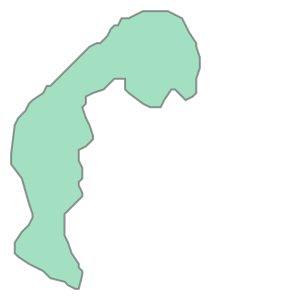

In [19]:
visium_sdata.shapes["lasso"].geometry.iloc[0]

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


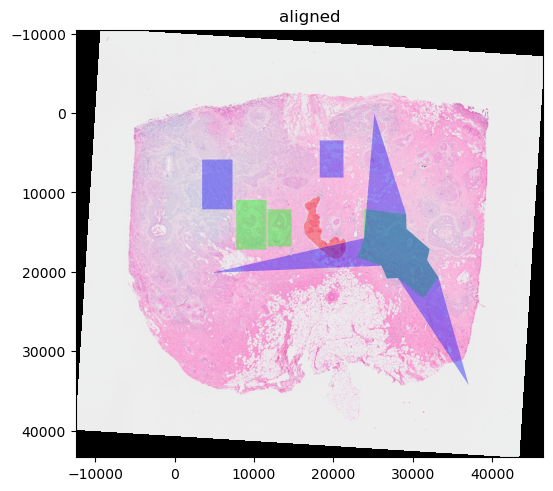

In [20]:
(
    visium_sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image")
    .pl.render_shapes("lasso", color="#ff000060")
    .pl.render_shapes("my_shapes", color="#00ff0060")
    .pl.render_shapes("my_shapes_2", color="#0000ff60")
    .pl.show(coordinate_systems="aligned")
)

## Extracting cells under the regions

Let's now find the cells under each of the three regions of interest and record, in the table as a categorical column, which category each cell belongs.
We will use the spatial query API `polygon_query()`; a separate tutorial is available for it and we will further assume the reader being familiar 
which such functionality.

Please note that, for how we constructed the shapes, some shapes overlap. In such case we will assign the labels of one of the categories (the one appearing last in our loop below).

Let's find, for each saved shape, the table of cells it contains.

In [21]:
from spatialdata import polygon_query
import anndata as ad
from collections import defaultdict

filtered_tables_unmerged: dict[str, list[ad.AnnData]] = defaultdict(list)
filtered_tables: dict[str, ad.AnnData] = {}

for shape in ["lasso", "my_shapes", "my_shapes_2"]:
    for polygon in visium_sdata[shape].geometry:
        table = polygon_query(visium_sdata, polygon=polygon, target_coordinate_system="aligned")["table"]
        filtered_tables_unmerged[shape].append(table)
    filtered_tables[shape] = ad.concat(filtered_tables_unmerged[shape])

/opt/miniconda3/envs/ome/lib/python3.11/site-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [22]:
filtered_tables

{'lasso': AnnData object with n_obs × n_vars = 102 × 18085
     obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
     obsm: 'spatial',
 'my_shapes': AnnData object with n_obs × n_vars = 575 × 18085
     obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
     obsm: 'spatial',
 'my_shapes_2': AnnData object with n_obs × n_vars = 973 × 18085
     obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
     obsm: 'spatial'}

Note that polygon_query only returns a table in case of the table annotating an element in the 
resulting queried `SpatialData` object. Other tables are filtered out. Should you want to keep 
tables that are not annotating any elements in the resulting `SpatialData` object, a parameter 
`filter_tables` set to `False` can be passed on to the `polygon_query` function. Which region(s) or 
elements a table annotates can be retrieved as follows:

In [23]:
from spatialdata import SpatialData

# Note that we could also do visium_sdata.get_annotated regions here. This is just meant to show we
# can also get annotated regions from a table outside a Spatialdata object.
print(SpatialData.get_annotated_regions(visium_sdata["table"]))

['CytAssist_FFPE_Human_Breast_Cancer']


It can be that a table is annotating an element but is still not returned after the polygon query. 
The reason in that case is that the resulting table didn't contain any rows annotating elements in 
the result of the query.

Now, let's add a categorical column to the original full table, named `'annotation'`, with default categorical value `'unassigned'`. Then, let's assign, for each row in the 3 subtables, its value to the name of the relative region of interest.

In [24]:
# it's important for the index to be unique
assert visium_sdata["table"].obs.index.is_unique

In [25]:
categories = ["unassigned"] + list(filtered_tables.keys())
n = len(visium_sdata["table"])

visium_sdata["table"].obs["annotation"] = pd.Categorical(["unassigned" for _ in range(n)], categories=categories)

for shape, subtable in filtered_tables.items():
    in_shape = subtable.obs.index
    visium_sdata["table"].obs["annotation"].loc[in_shape] = shape

/tmp/ipykernel_26892/3041238552.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  visium_sdata["table"].obs["annotation"].loc[in_shape] = shape


In [26]:
visium_sdata["table"].obs["annotation"].value_counts()

annotation
unassigned     3720
my_shapes_2     973
my_shapes       226
lasso            73
Name: count, dtype: int64

Let's visualize the result.

/opt/miniconda3/envs/ome/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Human_Breast_Cancer` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/opt/miniconda3/envs/ome/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata-data-converter/dependencies/spatialdata-plot/src/spatialdata_plot/pl/utils.py:798: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


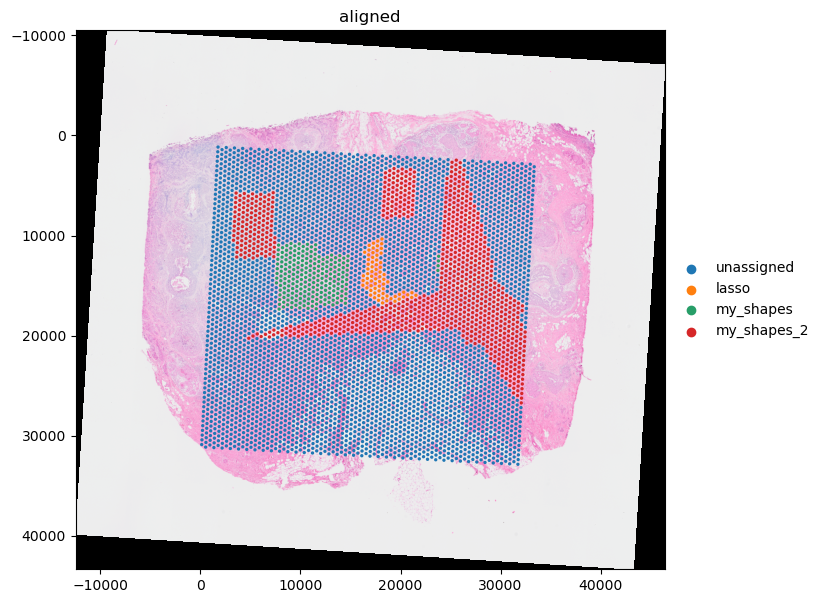

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
ax = plt.gca()
(
    visium_sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image")
    .pl.render_shapes("CytAssist_FFPE_Human_Breast_Cancer", color="annotation")
    # .pl.render_shapes("lasso", color="#00000040")
    # .pl.render_shapes("my_shapes", color="#00000040")
    # .pl.render_shapes("my_shapes_2", color="#00000040")
    .pl.show(coordinate_systems="aligned", ax=ax)
)

## Limitations

Currently we support saving rectangles, polygons and points with `napari` (see the landmark tutorial). We currently don't support saving circles, ellipses or segments. Furthermore, we ignore the style parameters that `napari` provides, such us fill color, border color, points size and line width. If you are interested in saving these types of annotations please get in touch with us or join the NGFF discussions on annotations in GitHub.
